## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import random
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN
import matplotlib.patches as mpatches
from sklearn.ensemble import IsolationForest
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

## Load the file

The data set can be found [here](https://github.com/numenta/NAB/tree/master/data/realKnownCause). 

In [3]:
atsf = pd.read_csv("ambient_temperature_system_failure.csv")
atsf.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


# Questions

## Question 1

Explore - Explain the shape and characteristic of the data. Use any visuals
you see fit to explain the shape of the data. Anything interesting you observe? Any other
insights you discovered? What other types of exploratory analysis would you like to do?

### Defining the dataset

In [4]:
print("The dataset is a timeseries with value representing the office temperature")
display(atsf.head())
print(f"Shape of the data set, total rows: {atsf.shape[0]}, total columns: {atsf.shape[1]}")
print("The data set ranges from 2013-07-04 to 2014-05-28 with the frequency of value being reported at intervals of an hour")
print(f"Data types for the columns: timestamp: {atsf.dtypes.timestamp}, value: {atsf.dtypes.value}")
print(f"Descriptive Statistics for value:")
display(atsf.describe())
print(f"The mean for temp is 71.24 and median is 71.8, meaning the outliers are not way obvious")

The dataset is a timeseries with value representing the office temperature


,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


Shape of the data set, total rows: 7267, total columns: 2
The data set ranges from 2013-07-04 to 2014-05-28 with the frequency of value being reported at intervals of an hour
Data types for the columns: timestamp: object, value: float64
Descriptive Statistics for value:


,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


The mean for temp is 71.24 and median is 71.8, meaning the outliers are not way obvious


### Converting datetime str to datetime object

In [5]:
# handling timestamps, as the timestamp value in the dataset is string

print(f"Type of timestamp value: {type(atsf.timestamp[0])}")
atsf['timestamp_dt'] = pd.to_datetime(atsf['timestamp'])
print(f"Type of timestamp value: {type(atsf.timestamp_dt[0])}")

Type of timestamp value: <class 'str'>
Type of timestamp value: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


### Finding inconsistancies
- missing values - There are no nulls in the dataset. 
- duplicates - There are no duplicates in the data, each timestamp has one value

In [6]:
## checking for null values
print(atsf.isnull().sum())
## checking for duplicates
atsf.drop_duplicates().shape

timestamp       0
value           0
timestamp_dt    0
dtype: int64


(7267, 3)

### Visualizing the entire dataset

From the line graph we can visualize how the temperature varies by time. There is some relation to the month, which we need to explore. We don't have enough data to verify wether the variation in the data by months is through seasonlity. There also might be some seasonlity by hour the day, which will be looked into further. 

The histogram gives us an idea of the spread of the temperature values. The spread follows bell curve, with 99.7% of the data lying between 3 std deviations on the data. This means that point outliers or huge discrimantory outliers don't exist in the data. The red lines represent 3 std deviation from the mean.

The box plot indicates that there are values above 80 degrees and below 60 degrees that can be considered outliers. We are going to dig into this deeper

#### Line graph of temperature values

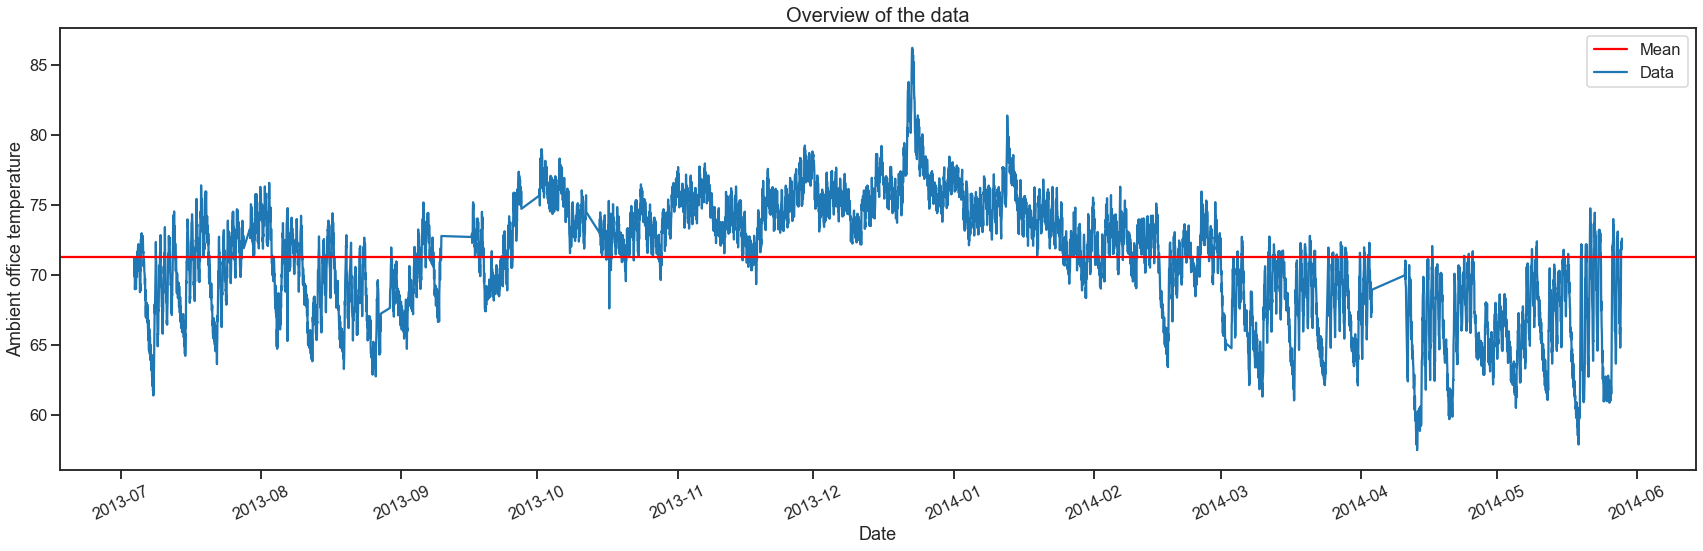

In [6]:
## get a glimpse of how the data set looks visually
fig = plt.figure(figsize =(24, 8))
sns.lineplot(x = "timestamp_dt", y = "value",data = atsf)
plt.axhline(atsf['value'].mean(), color='red')
_ = plt.xticks(rotation = 25)
a = plt.Line2D([],[],color='red', linestyle='-')
b = plt.Line2D([],[], linestyle='-')
plt.legend([a,b],['Mean','Data'])
plt.title('Overview of the data', fontsize=20)
plt.ylabel('Ambient office temperature')
plt.xlabel('Date')
plt.tight_layout()


#### Histogram of temperature values

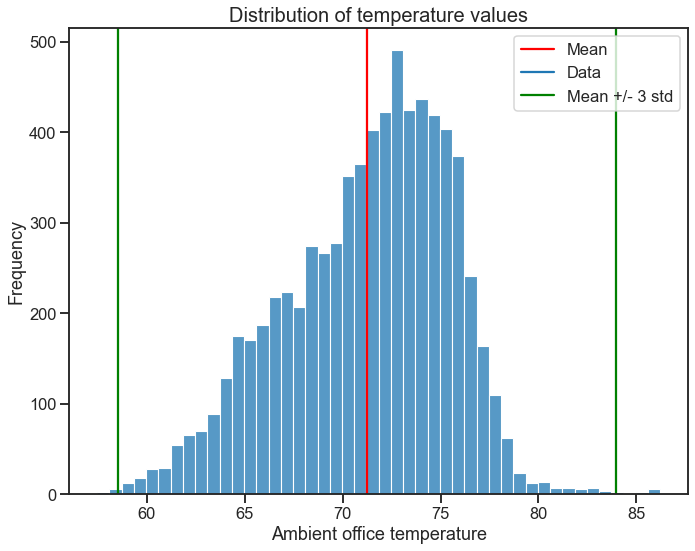

In [7]:
# from the histogram we can see that value above 80 can be the outliers. This is given there is no seasnolity in the data. 
#ul = atsf['value'].mean() + 3 * atsf['value'].std()
#ll = atsf['value'].mean() - 3 * atsf['value'].std()
#atsf.query(f"{ll}<= value <= {ul}").shape[0]/atsf.shape[0]

fig = plt.figure(figsize =(10, 8))
sns.histplot(atsf['value'])
plt.axvline(atsf['value'].mean(), color='red')
plt.axvline(atsf['value'].mean() + 3 * atsf['value'].std(), color = 'green')
plt.axvline(atsf['value'].mean() - 3 * atsf['value'].std(), color = 'green')

a = plt.Line2D([],[],color='red', linestyle='-')
b = plt.Line2D([],[], linestyle='-')
c = plt.Line2D([],[], linestyle='-', color='green')
plt.legend([a,b,c],['Mean','Data','Mean +/- 3 std'])
plt.title('Distribution of temperature values', fontsize=20)
plt.xlabel('Ambient office temperature')
plt.ylabel('Frequency')
plt.tight_layout()

#### Box plot of temperature values

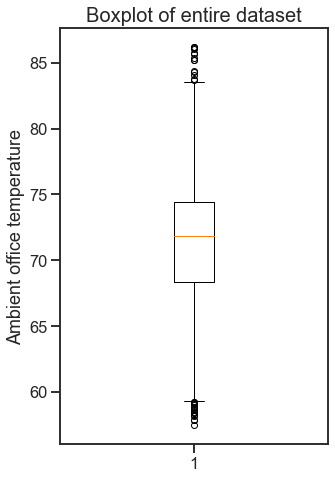

In [7]:
fig = plt.figure(figsize =(5, 7))
plt.boxplot(atsf.value)
plt.ylabel('Ambient office temperature')
plt.title('Boxplot of entire dataset', fontsize=20)
plt.tight_layout()

### Highlevel insigts

The data set shows us the sensor values of an office. Let's assume that the office is temperature controlled and is usally set for room temperature between 68 to 77 as said in the guidelines by US EPA. The HVAC system uses these sensor values to control its elements (switch on heating vs cooling). From looking at the distribution, whenever temperature goes above 77, cooling systems should activate, and whenever temperature goes below 68, heating systems should activate. For this we should have high confidence in the reported sensor values. 
By the plots, it seems like the temperature corrects itself in a few hours, which makes sense, as if HVAC system activates it will take some time for the room temperature to actually change and for the sensor to detect them. 
But there are instances where it looks like the sensor values are out of range and they are not going back to average room temperature. Lets dive into detecting these cases  

## Question 2

What features would you like to build to extend the data set? Extend your data set with these new features you identified in the previous
step. Explore your newly transformed data now. Anything interesting you observe?

### Creating new time features

We break down the datetime by month, date, and hour to see if there are any underlying seasonal trends.
The first plot picks three random dates and plots their data by hour, which shows that there is no obvious trend by hour.  
The second graph shows the distribtion of data by hour. We see the mean temperaute ranges between 70 to 72, so its within the suggested room temperature. The spread upto 50% percentil is similar among hours.
The third graph shows the distribution of data by month. Here we can clearly see a trend,the ambeint temperature drops between Februry and May. 
For december and January we can see outliers on the higher side, this could be because the heating was left on for too long, or the sesnors aren't picking up the correct values. This is something our outlier ddetection algorithm should pick on.
The fourth graph is a heatmap which further indicates our observation using box plots. There are some hours that missing data, but since we dont have infomration on why there is missing data, we will not dig into it

#### New features

In [14]:
atsf['month-year'] = atsf['timestamp_dt'].dt.to_period('M')

atsf['month'] = atsf['timestamp_dt'].dt.month

atsf['year'] = atsf['timestamp_dt'].dt.year

atsf['hour'] = atsf['timestamp_dt'].dt.hour

atsf['day'] = atsf['timestamp_dt'].dt.day

atsf['date'] = atsf['timestamp_dt'].dt.date

atsf.head()

,timestamp,value,timestamp_dt,cluster,anomaly_CART,month-year,month,year,hour,day,date
0,2013-07-04 00:00:00,69.880835,2013-07-04 00:00:00,4,1,2013-07,7,2013,0,4,2013-07-04
1,2013-07-04 01:00:00,71.220227,2013-07-04 01:00:00,4,1,2013-07,7,2013,1,4,2013-07-04
2,2013-07-04 02:00:00,70.877805,2013-07-04 02:00:00,4,1,2013-07,7,2013,2,4,2013-07-04
3,2013-07-04 03:00:00,68.959400,2013-07-04 03:00:00,4,1,2013-07,7,2013,3,4,2013-07-04
4,2013-07-04 04:00:00,69.283551,2013-07-04 04:00:00,4,1,2013-07,7,2013,4,4,2013-07-04


#### Random Dates

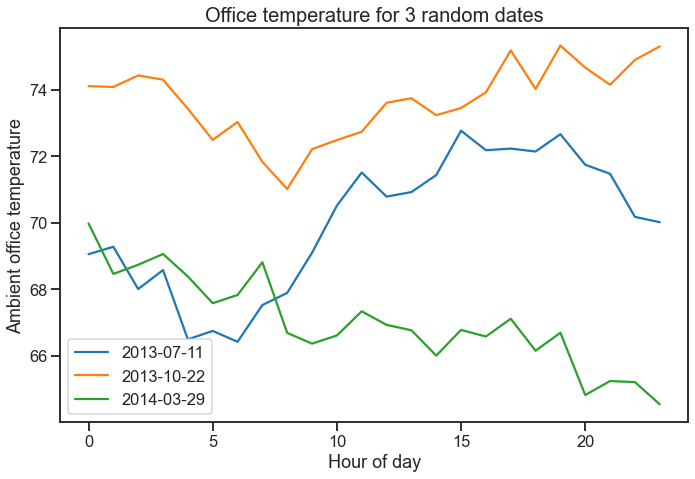

In [10]:
### now lets look at one day of data
fig = plt.figure(figsize =(10, 7))
random_dates = random.sample(list(atsf.date.unique()),3)#.sample()

for rd in random_dates:
    plot_df = atsf[atsf['date'] == rd]
    sns.lineplot(x = "hour", y = "value",data = plot_df)

a = plt.Line2D([],[],color=sns.color_palette()[0], linestyle='-')
b = plt.Line2D([],[], linestyle='-',color=sns.color_palette()[1])
c = plt.Line2D([],[], linestyle='-', color=sns.color_palette()[2])
plt.legend([a,b,c],random_dates)
plt.title('Office temperature for 3 random dates', fontsize=20)
plt.xlabel('Hour of day')
plt.ylabel('Ambient office temperature')
plt.tight_layout()

#### Trend by hour

The median temperature for all hours ranges between 70 to 75. 

In [11]:
atsf.groupby('hour')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,304.0,71.517858,4.431082,58.423639,68.424502,72.160310,75.110241,85.326165
1,304.0,71.222044,4.579400,57.861906,67.807410,72.087219,74.842971,85.705990
2,303.0,71.079827,4.695541,58.639295,67.716816,71.563000,74.714545,84.086971
3,303.0,70.833176,4.654960,58.862275,67.297671,71.460464,74.422304,85.222277
4,302.0,70.562770,4.703470,58.777141,66.881578,71.144730,74.157270,83.653968
5,301.0,70.306501,4.650874,59.410747,66.537415,70.865268,73.936818,84.329000
6,301.0,70.059263,4.676267,57.844573,66.340303,70.376201,73.661552,83.118241
7,301.0,69.992256,4.526940,58.389522,66.217465,70.326111,73.359198,82.627288
8,301.0,70.085428,4.392794,59.125023,66.599543,70.278531,73.500426,82.622298


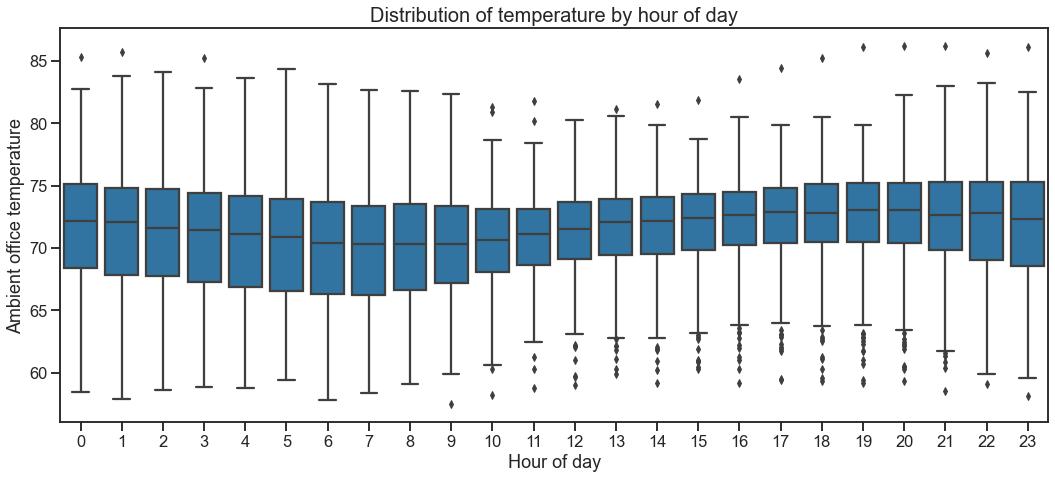

In [22]:
fig = plt.figure(figsize =(15, 7))

sns.boxplot(x="hour", y="value", data=atsf, color=sns.color_palette()[0])

plt.title('Distribution of temperature by hour of day', fontsize=20)
plt.xlabel('Hour of day')
plt.ylabel('Ambient office temperature')
plt.tight_layout()

#### Trend in months

In [32]:
atsf.groupby('month')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,744.0,74.243393,2.064824,68.333123,72.935924,74.277431,75.590940,81.376188
2,672.0,71.643594,2.130366,63.391750,70.629726,71.972647,73.042494,76.294915
3,699.0,67.635159,2.761744,61.013651,65.490281,67.737555,70.063059,72.778207
4,547.0,66.144435,3.241942,57.458406,64.164285,66.313559,68.771500,72.286822
5,664.0,66.449333,3.592080,57.861906,63.643765,66.337997,69.290852,74.745938
7,640.0,70.289853,3.034837,61.364476,68.295779,70.679452,72.620643,76.390019
8,697.0,69.289786,2.945139,62.731328,67.052488,69.170319,71.588454,76.569502
9,478.0,70.863810,2.520719,64.699379,68.958392,70.716128,72.731375,77.361491
10,662.0,73.972191,1.811469,67.592208,72.640433,73.831185,75.299240,78.985425


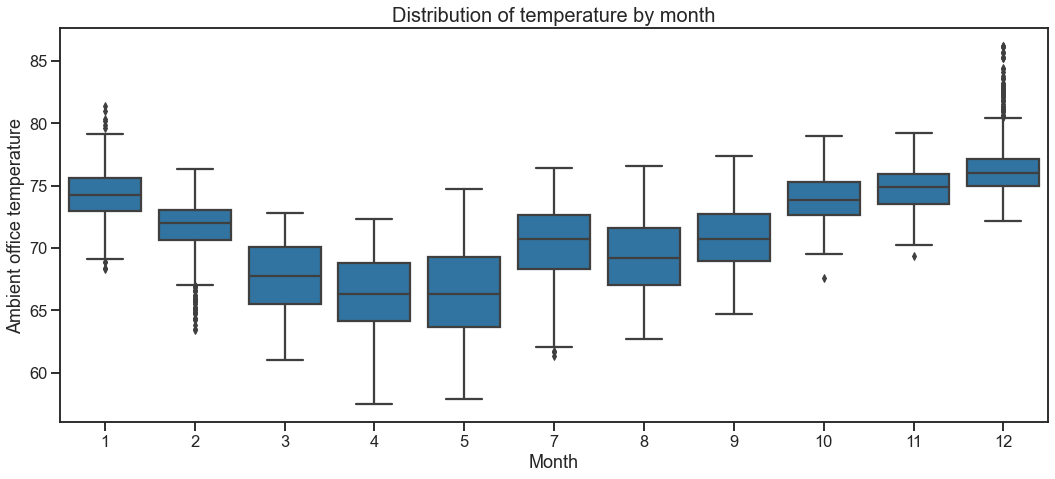

In [33]:
fig = plt.figure(figsize =(15, 7))

sns.boxplot(x="month", y="value", data=atsf, color=sns.color_palette()[0])

plt.title('Distribution of temperature by month', fontsize=20)
plt.xlabel('Month')
plt.ylabel('Ambient office temperature')
plt.tight_layout()

<AxesSubplot:>

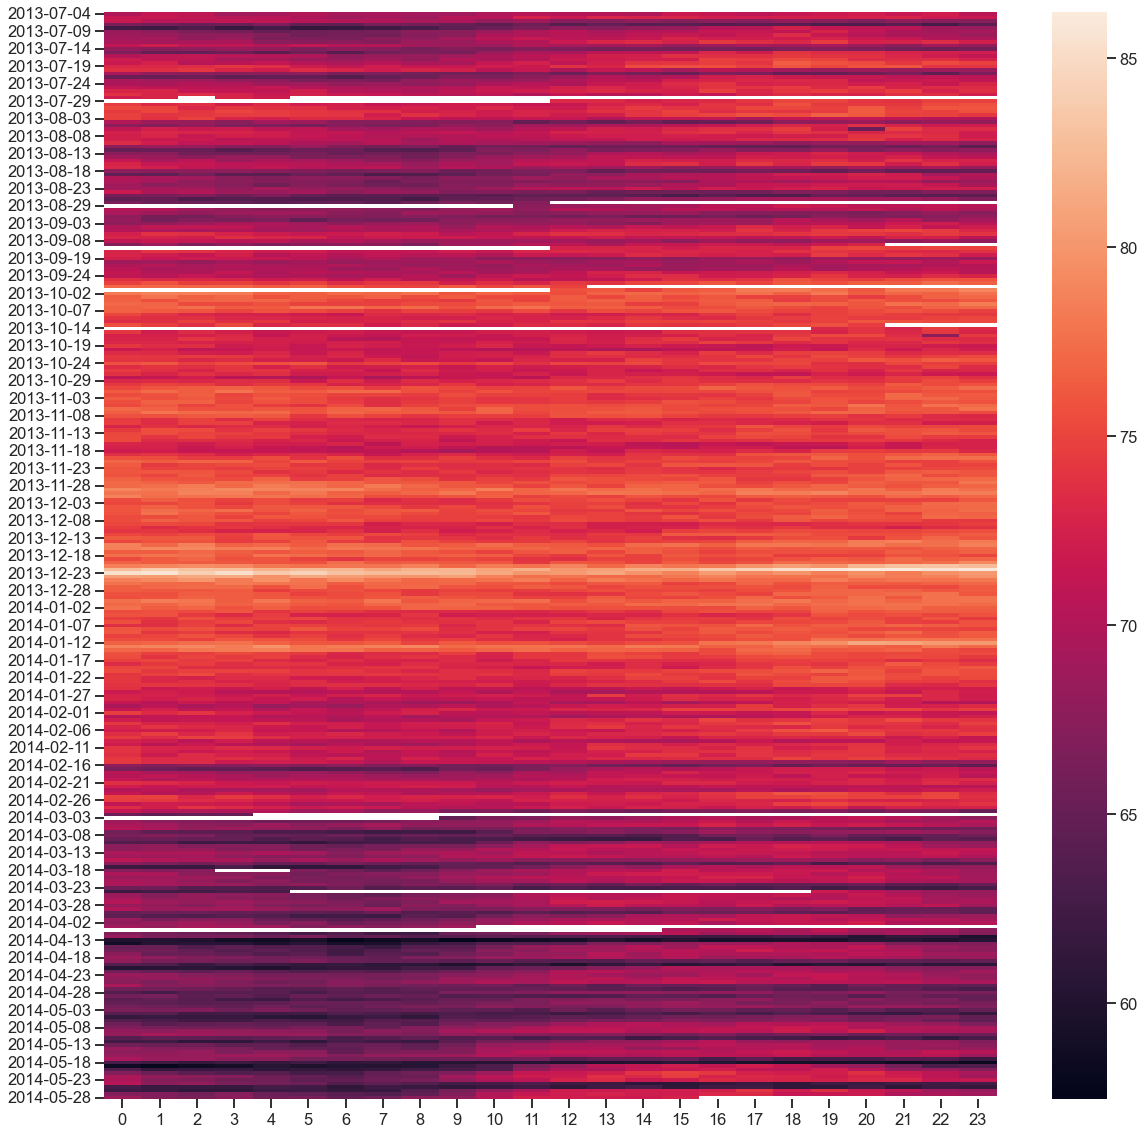

In [31]:
# Heatmap showing that there is no trend based on hour of day, the only trend observed is based on month
# This did show that we have some missing information in our dataset

# for_plot = {}
# for _, row in atsf.iterrows():
#     if row.date not in for_plot:
#         for_plot[row.date] = {}
#     if row.hour not in for_plot[row.date]:
#         for_plot[row.date][row.hour] = 0
#     for_plot[row.date][row.hour] = row.value
# for_plot = pd.DataFrame.from_dict(for_plot, orient='index')
# fig,ax = plt.subplots(figsize=(20,20))
# for_plot = for_plot.sort_index()
# sns.heatmap(for_plot,ax=ax)

## Question 3

Anomaly Detection - Statistical Model - Any statistical model you canidentify to find outliers?

### Statistical methods

One statistical method that can be used is around z-tests. The test takes mean and std into consideration to find outliers. The test assumes that the data is normally ditributed and there is no underlying trend. From the above graphs though we see some variation, we cant tell if there is an underlying trend. So lets check that using the test of stationairty. Using the p-value, we can clearly reject the null hypothesis, stating that there is no time dependencein the data. 

Lets first use the std deviation test with overall mean and std, we can see that it does well on the extremes in Dec and May. But it does not pick the extremes in Jan. It could be because of variation in the monthly data. Lets use the monthly means to see the outliers. The graph shows picks up on the high temperatures in December and Jan, and the low temperatures in Feb. It does not pick up extreme low temperatures in April and June. Though this is a good baseline, its not a well suited method. We want to be able to pick points that look out of place and might lead to falsely triggering the HVAC system. 
The third graph takes into assumption that since withing hours and days there is no specific trend, moving averages should give us an idea of when sensor values are outliers. Taking the moving average of 24 hours in a week, we can see that graph does well in the inital months, but fails to pick colder temperatures in the later months, as there is a gradual decrease in the mean temperature during those months.
The three graphs combined can be used to make an alert system, though some domain knowledge would be required from the HVAC system analysts. We don't want to trigger false alarms, but also don't want to keep people in uncomfortable conditions. Looking into the root cuase of those collective outliers is crucial in understadning which system is failing there. 


There are other methods such as forecasting using mean absolute percentage error, and ARIMA using moving averages, but these methods require training data and we don't have a large enough data set. These methods are advantagouse when we want to find local outliers, but in our case as seen from moviing averages local outliers will trigger false alarms, as having a temp of 75 within a range of 70-72 is not an outlier. Other deep learning methods such as LSTM can work but lets try clustering to see if that can help us.

#### Looking at stationairty of the data

In [35]:
adtest = adfuller(atsf.value)
print('ADF Statistic: %f' % adtest[0])
print('p-value: %f' % adtest[1])

ADF Statistic: -5.517563
p-value: 0.000002


In [36]:
def find_z_outlier(mean_column,std_column, std_limit):
    atsf['upper_limit'] = atsf[mean_column] + 3 * atsf[std_column]
    atsf['lower_limit'] = atsf[mean_column] - 3 * atsf[std_column]
    return atsf.query("value > upper_limit or value < lower_limit")

#### Using overall mean and std

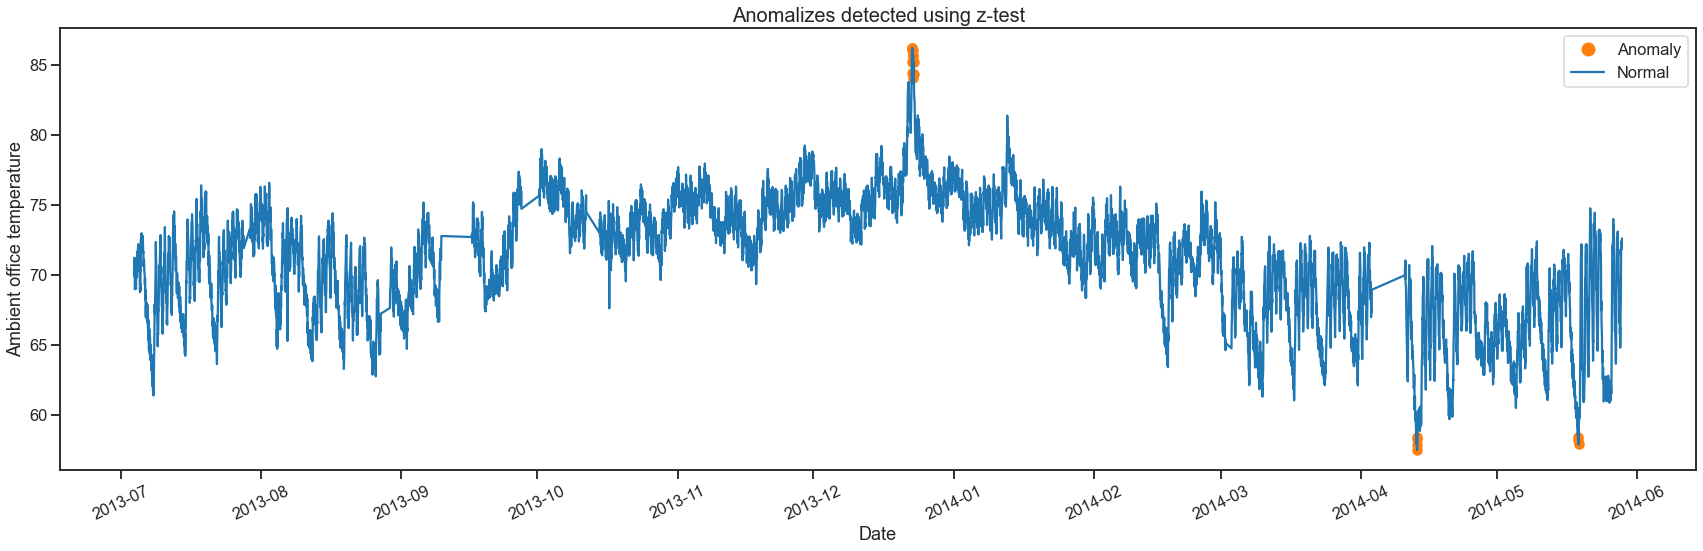

In [46]:
atsf['mean'] = atsf['value'].mean()
atsf['std'] = atsf['value'].std()
a = find_z_outlier('mean','std', 2.5) #anomaly
# visualization
fig, ax = plt.subplots(figsize=(24,8))
ax.plot(atsf.timestamp_dt, atsf['value'], color=sns.color_palette()[0])
ax.scatter(a.timestamp_dt,a['value'], color=sns.color_palette()[1])

_ = plt.xticks(rotation = 25)
a = plt.Line2D([],[],color='w', marker='o', markerfacecolor=sns.color_palette()[1], markersize=15)
b = plt.Line2D([],[], linestyle='-')
plt.legend([a,b],['Anomaly','Normal'])
plt.title('Anomalizes detected using z-test', fontsize=20)
plt.ylabel('Ambient office temperature')
plt.xlabel('Date')
plt.tight_layout()

#### Using monthy mean and std

In [48]:
monthly_mean = atsf.groupby('month')['value'].mean().reset_index() # calculate monthly mean
monthly_mean.columns = ['month','monthly_mean']
monthly_std = atsf.groupby('month')['value'].std().reset_index() # calculate montlhy std
monthly_std.columns = ['month','monthly_std']
### monthly mean and std
atsf = atsf.merge(monthly_mean, on = 'month').merge(monthly_std, on = 'month') # merge to main df

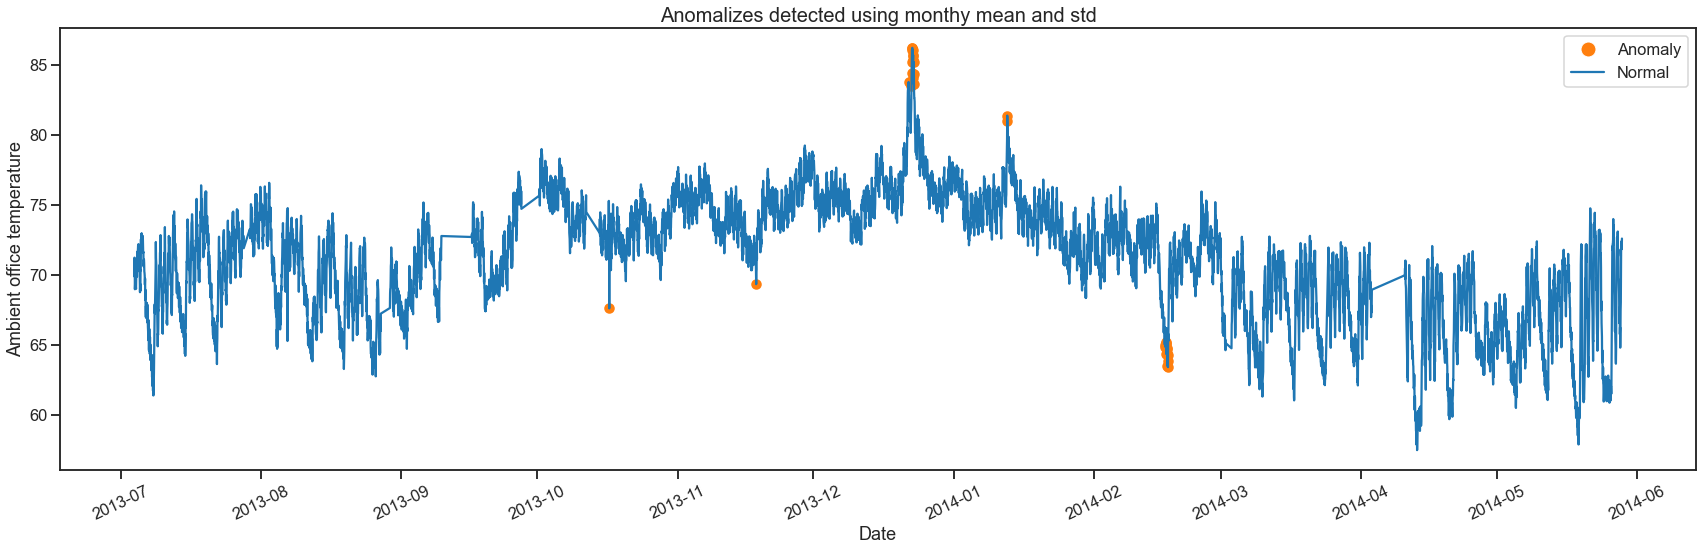

In [53]:
a = find_z_outlier('monthly_mean','monthly_std', 2.5) #anomaly
# visualization
fig, ax = plt.subplots(figsize=(24,8))
ax.plot(atsf.timestamp_dt, atsf['value'], color=sns.color_palette()[0])
ax.scatter(a.timestamp_dt,a['value'], color=sns.color_palette()[1])
_ = plt.xticks(rotation = 25)
a = plt.Line2D([],[],color='w', marker='o', markerfacecolor=sns.color_palette()[1], markersize=15)
b = plt.Line2D([],[], linestyle='-')
plt.legend([a,b],['Anomaly','Normal'])
plt.title('Anomalizes detected using monthy mean and std', fontsize=20)
plt.ylabel('Ambient office temperature')
plt.xlabel('Date')
plt.tight_layout()

#### Using rolling mean and std

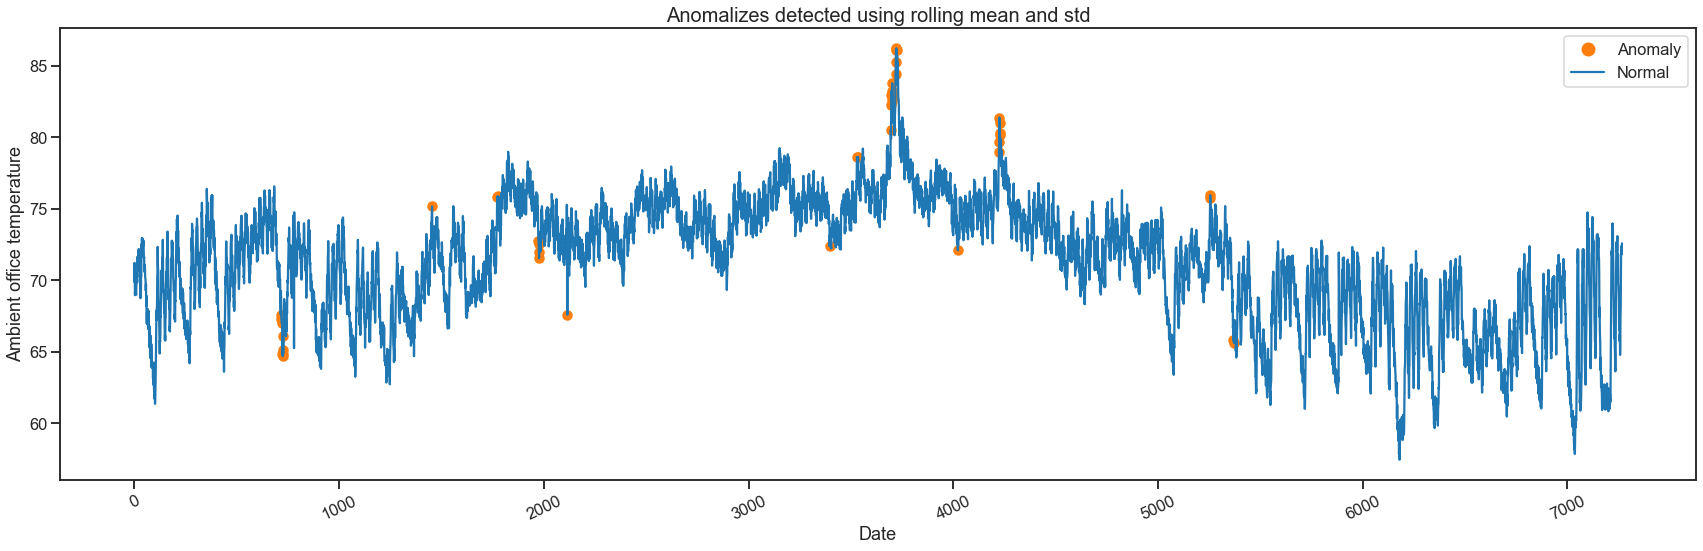

In [54]:
atsf['rolling_mean'] = atsf['value'].rolling(168).mean()
atsf['rolling_std'] = atsf['value'].rolling(168).std()
a = find_z_outlier('rolling_mean','rolling_std', 2.5) #anomaly
# visualization
fig, ax = plt.subplots(figsize=(24,8))
ax.plot(atsf.index, atsf['value'], color=sns.color_palette()[0])
ax.scatter(a.index,a['value'], color=sns.color_palette()[1])

_ = plt.xticks(rotation = 25)
a = plt.Line2D([],[],color='w', marker='o', markerfacecolor=sns.color_palette()[1], markersize=15)
b = plt.Line2D([],[], linestyle='-')
plt.legend([a,b],['Anomaly','Normal'])
plt.title('Anomalizes detected using rolling mean and std', fontsize=20)
plt.ylabel('Ambient office temperature')
plt.xlabel('Date')
plt.tight_layout()

## Question 4
Anomaly Detection using Clustering - What clustering approach would you use to identify anomalies? Please share your results.

### Clustering

There are a few clustering methods such as Kmeans and DBSCAN available. There is HDBSCAN method that uses heirarchial DBSCAN to cluster values. Based on the number of clusters and clusters size, we get an outlier score. I am being conservative in this approach and expecting that even a slight change should be detected. By looking at the distribution of the outlier score, setting a threshold of 0.7 will give us all the points that are extremes, which is around 3% of the data. From the graph we can also see that this method is able to pick all the colder points which the statistcal methods missed.

#### Scaling the values

In [10]:
scaler = StandardScaler() # lets first scale the data to mean 0 and std -1
np_scaled = scaler.fit_transform(atsf['value'].values.reshape(-1,1))

#### Clustering using HDBSCAN

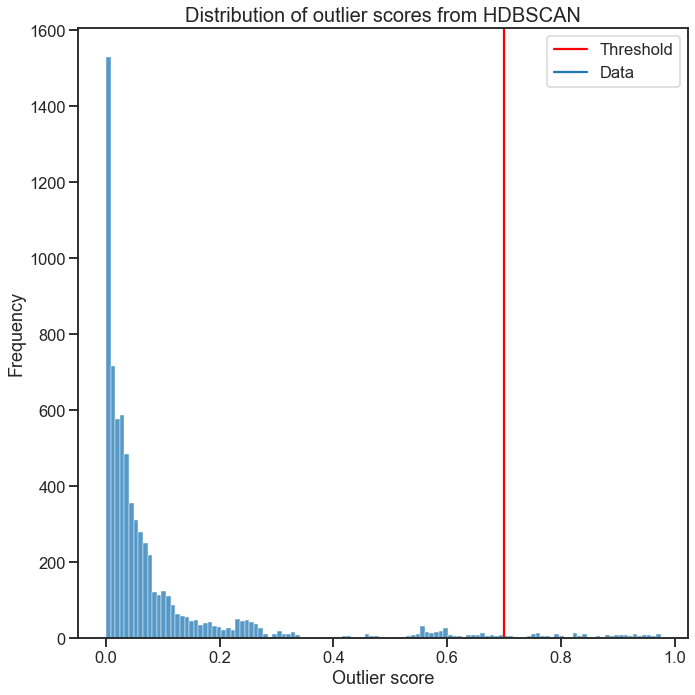

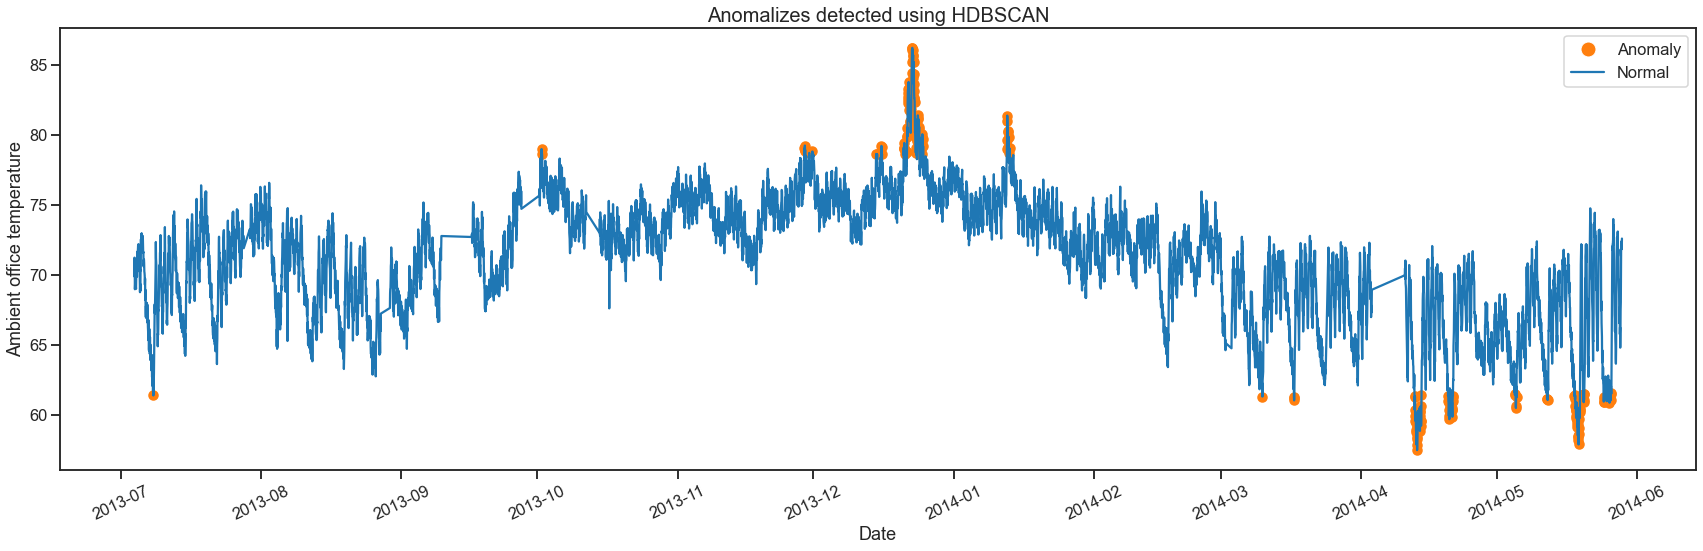

In [11]:
clustering = HDBSCAN(min_cluster_size=25,min_samples = 100).fit(np_scaled)
atsf['cluster'] = clustering.labels_
atsf['cluster'].unique()

fig,ax = plt.subplots(figsize=(10,10))
sns.histplot(clustering.outlier_scores_)
plt.axvline(0.7,color='red')

a = plt.Line2D([],[],color='red', linestyle='-')
b = plt.Line2D([],[], linestyle='-')

plt.legend([a,b],['Threshold','Data'])
plt.title('Distribution of outlier scores from HDBSCAN', fontsize=20)
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.tight_layout()


fig, ax = plt.subplots(figsize=(24,8))
ax.plot(atsf.timestamp_dt, atsf['value'], color=sns.color_palette()[0])
_id = atsf.index[np.where(clustering.outlier_scores_ > 0.7)]
x = atsf[atsf.index.isin(_id)]['timestamp_dt']; y = atsf[atsf.index.isin(_id)].value
plt.scatter(x,y,color=sns.color_palette()[1])


_ = plt.xticks(rotation = 25)
a = plt.Line2D([],[],color='w', marker='o', markerfacecolor=sns.color_palette()[1], markersize=15)
b = plt.Line2D([],[], linestyle='-')
plt.legend([a,b],['Anomaly','Normal'])
plt.title('Anomalizes detected using HDBSCAN', fontsize=20)
plt.ylabel('Ambient office temperature')
plt.xlabel('Date')
plt.tight_layout()

## Question 5
A nomaly Detection using Classification - What classification approach would you use to identify anomalies? Please share your results.

### Classification

We will use Isolation Forrest as method to classify the outliers. Using what we have learnt above lets take the outlier fraction to be around 3%. We can see that the we get most of collective as well as point outleirs using this method. 

#### Isolation Forrest

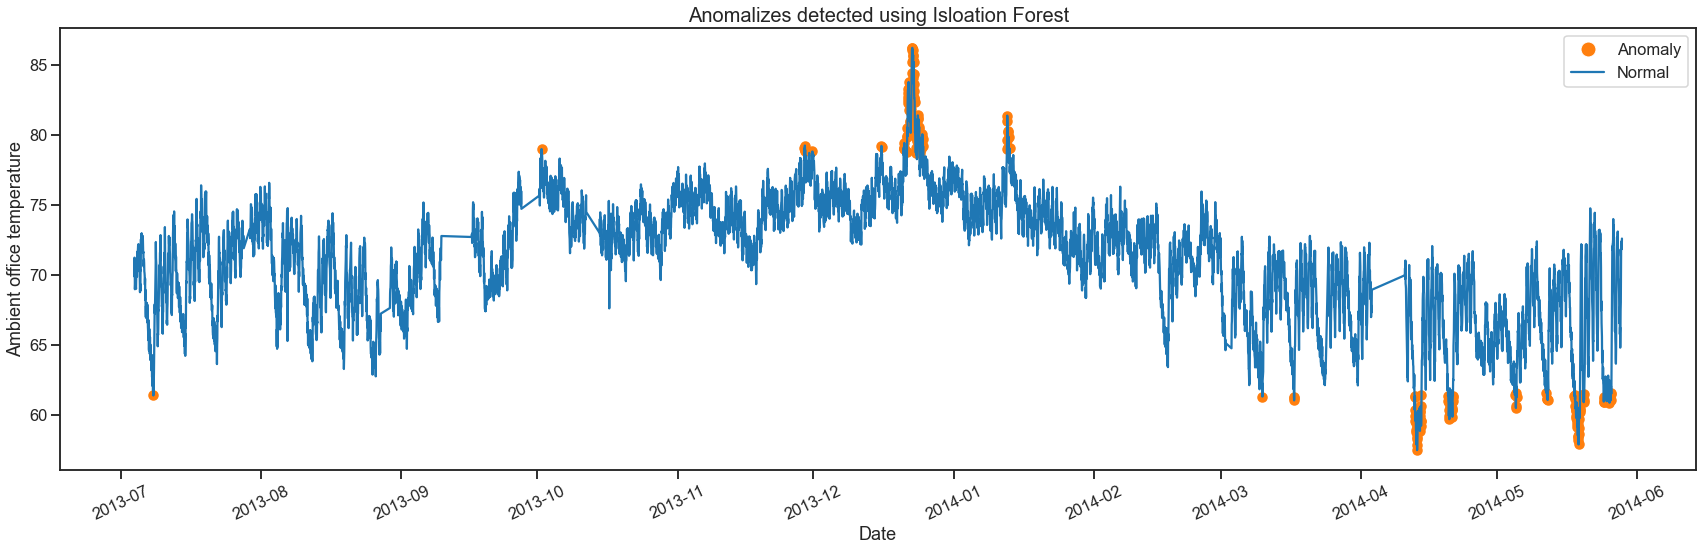

In [12]:
outliers_fraction = float(.03) ## This is saying we have 1% outliers in the data
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)
atsf['anomaly_CART'] = model.predict(data)
# visualization
fig, ax = plt.subplots(figsize=(24,8))
a = atsf.loc[atsf['anomaly_CART']== -1] #anomaly
ax.plot(atsf.timestamp_dt, atsf['value'], color=sns.color_palette()[0])
ax.scatter(a.timestamp_dt,a['value'], color=sns.color_palette()[1])

_ = plt.xticks(rotation = 25)
a = plt.Line2D([],[],color='w', marker='o', markerfacecolor=sns.color_palette()[1], markersize=15)
b = plt.Line2D([],[], linestyle='-')
plt.legend([a,b],['Anomaly','Normal'])
plt.title('Anomalizes detected using Isloation Forest', fontsize=20)
plt.ylabel('Ambient office temperature')
plt.xlabel('Date')
plt.tight_layout()

In [191]:
#outliers_fraction = float(.03) ## This is saying we have 1% outliers in the data
#scaler = StandardScaler()
#np_scaled = scaler.fit_transform(atsf['rolling_mean'].values.reshape(-1,1))
#data = pd.DataFrame(np_scaled[~np.isnan(np_scaled)])
# train isolation forest
#model =  IsolationForest(contamination=outliers_fraction)
#model.fit(data)
#
#atsf.loc[167:,'anomaly_CART'] = model.predict(data)
# visualization
#fig, ax = plt.subplots(figsize=(20,6))
#a = atsf.loc[atsf['anomaly_CART']== -1] #anomaly
#ax.plot(atsf.index, atsf['rolling_mean'], color='blue', label = 'Normal')
#ax.scatter(a.index,a['rolling_mean'], color='red', label = 'Anomaly')
#plt.legend()
#plt.show();

## Question 6
How will you present your findings

### Final thoughts

The three methods give us a good idea of when the temperature values look erranous or out of place. Investigating the cause of these values is important as these methods suggest there is some issue but don't tell us what the issue is. For example in the case of December when the temperature touches 85, the chances of outisde temperature being that high is low, so if the sensor values are registering those values, one needs to look into it. In this case one can say that if it was just one value out of blue, then it was a point anamoly and may be the sensor registered an errounos reading. But we see that those outliers are collective, suggesting that there could be an issue with the HVAC system and the temperature in the office has reached 85 degrees. In the other case of registering an anomaly in July, we see that the temperature is starts dropping on 7th but goes back up on 8th, and our model picks up on the lowest value. 
Thus knowing the root cuase of these readings is important for understanding the problem at hand and taking an action. The action could be triggering the HVAC system or monitoring the system, and depending on the purpose we would need to set some ground rules and heauristics for evaluting these models.

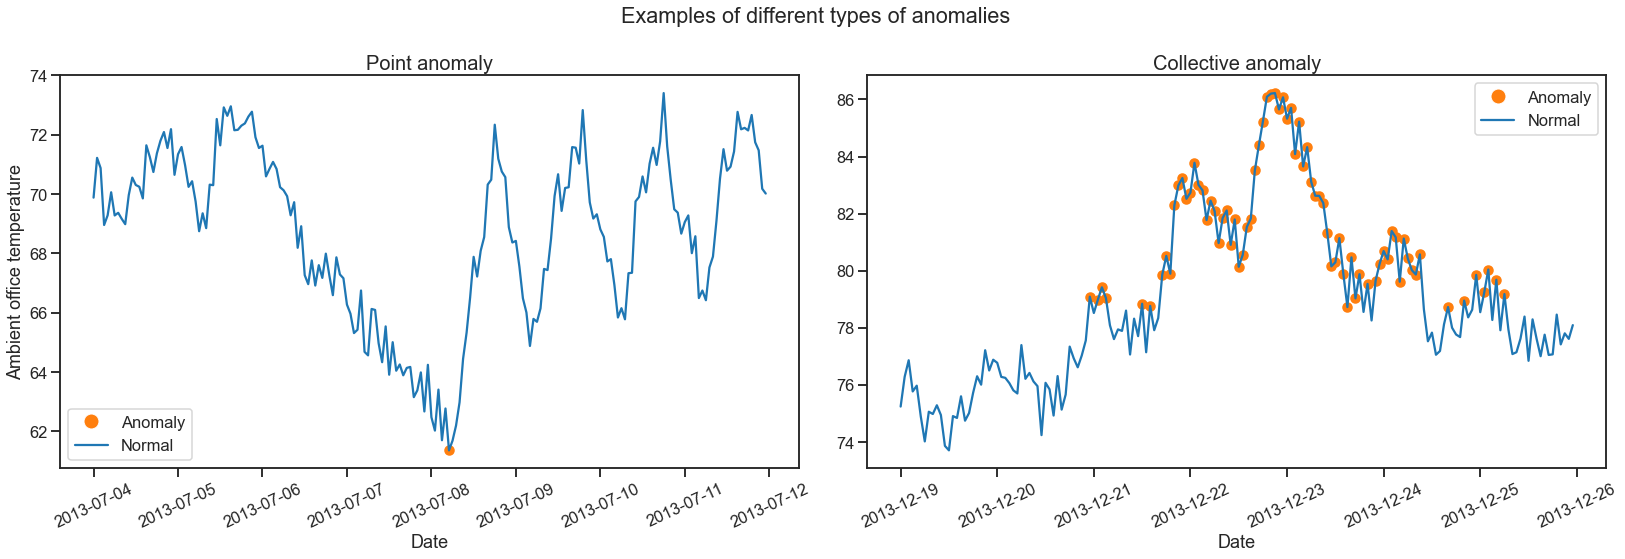

In [16]:
fig, ax = plt.subplots(figsize=(23,8), ncols=2, sharey=False)
a = atsf.loc[atsf['anomaly_CART']== -1] #anomaly

subset = atsf[atsf.date.between(left=dt.date(2013,7,4),right=dt.date(2013,7,11))]
a = subset.loc[subset['anomaly_CART']== -1] #anomaly

ax[0].plot(subset.timestamp_dt, subset['value'], color=sns.color_palette()[0])
ax[0].scatter(a.timestamp_dt,a['value'], color=sns.color_palette()[1])

plt.setp( ax[0].xaxis.get_majorticklabels(), rotation=25)
a = plt.Line2D([],[],color='w', marker='o', markerfacecolor=sns.color_palette()[1], markersize=15)
b = plt.Line2D([],[], linestyle='-')
ax[0].legend([a,b],['Anomaly','Normal'])
ax[1].legend([a,b],['Anomaly','Normal'])
ax[0].set_title('Point anomaly', fontsize=20)
ax[0].set_ylabel('Ambient office temperature')
ax[0].set_xlabel('Date')


a = atsf.loc[atsf['anomaly_CART']== -1] #anomaly
subset = atsf[atsf.date.between(left=dt.date(2013,12,19),right=dt.date(2013,12,25))]
a = subset.loc[subset['anomaly_CART']== -1] #anomaly

ax[1].plot(subset.timestamp_dt, subset['value'], color=sns.color_palette()[0])
ax[1].scatter(a.timestamp_dt,a['value'], color=sns.color_palette()[1])
ax[1].set_title('Collective anomaly', fontsize=20)
ax[1].set_xlabel('Date')
plt.setp( ax[1].xaxis.get_majorticklabels(), rotation=25)

plt.suptitle('Examples of different types of anomalies')
plt.tight_layout()